In [212]:
import tensorflow as tf
keras = tf.keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
# from tensorflow.keras.embeddings import Embedding
# from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb
import pandas as pd
import seaborn as sns

# from src.LSTM_cleaning import *
from src.EDA import *

import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')

In [213]:
# autoreload python file to take in changes from outside notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
eda = EDA()
pre_process = Prepocessing()

In [53]:
df = pd.read_csv('sephora_review_db.csv.zip')

In [54]:
model_df = df[['review_text', 'skin_type']].copy()
model_df.head()

,review_text,skin_type
0,Really good foundation I like it a lot but som...,oily
1,"As someone who is very VERY fair, I have alway...",combination
2,First purchase of a foundation of any kind. Wa...,combination
3,I absolutely love this foundation! I get compl...,combination
4,Love this foundation! I was using Too Faced Bo...,combination


In [153]:
model_df['review_text'] = model_df['review_text'].apply(format_strings)
model_df.head()

,review_text,skin_type
0,really good foundation like lot sometimes grab...,oily
1,"someone fair, always hard time finding foundat...",combination
2,first purchase foundation kind. willing give t...,combination
3,absolutely love foundation! get compliments da...,combination
4,love foundation! using faced born way bought b...,combination


In [60]:
eda.missing_zero_values_table(model_df)

Your selected dataframe has 2 columns and 276072 Rows.
There are 1 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
skin_type,0,141630,51.3,141630,51.3,object


It looks like half of the skin types are missing, these rows will be dropped as an NaN skin type does not have much meaning in this context.

In [8]:
model_df.dropna(inplace=True, axis=0)

In [9]:
eda.missing_zero_values_table(model_df)

Your selected dataframe has 2 columns and 134442 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In order to figure out the max token length, I will first check to see what the average and max review length is for my dataset

In [10]:
num_tokens = [len(review.split()) for review in model_df['review_text']]
num_tokens = np.array(num_tokens)
# find average length of review
avg_review_length = np.mean(num_tokens)
print('Avg review length: ', int(avg_review_length))
# find max length of review
max_review_length = np.max(num_tokens)
print('Max review length: ', max_review_length)
# len(model_df['review_text'][0].split())

Avg review length:  36
Max review length:  481


Calculate the max the number of tokens to put into the model by taking the average review length plus 2 standard deviations.

In [11]:
max_tokens = int(avg_review_length + (2 * np.std(num_tokens)))
max_tokens

93

This max token length covers around 95% of the dataset.

In [12]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9545528926972225

## LSTM Model predicting Dry & Oily Skin

Compared to the Gradient Boosting Classifier model from before, the LSTM model performs a little bit better with 75% Accuracy, 77% Precision, and 77% Recall. The model's loss and accuracy start to 

Train on 41476 samples, validate on 4609 samples
Epoch 1/10
41476/41476 [==============================] - 228s 5ms/sample - loss: 0.6086 - accuracy: 0.6487 - val_loss: 0.4984 - val_accuracy: 0.7435
Epoch 2/10
41476/41476 [==============================] - 232s 6ms/sample - loss: 0.5226 - accuracy: 0.7191 - val_loss: 0.4634 - val_accuracy: 0.7626
Epoch 3/10
41476/41476 [==============================] - 228s 5ms/sample - loss: 0.4855 - accuracy: 0.7504 - val_loss: 0.4601 - val_accuracy: 0.7576
Epoch 4/10
41476/41476 [==============================] - 227s 5ms/sample - loss: 0.4684 - accuracy: 0.7607 - val_loss: 0.4589 - val_accuracy: 0.7609
Epoch 5/10
41476/41476 [==============================] - 228s 5ms/sample - loss: 0.4538 - accuracy: 0.7703 - val_loss: 0.4604 - val_accuracy: 0.7581
Epoch 6/10
41476/41476 [==============================] - 212s 5ms/sample - loss: 0.4449 - accuracy: 0.7736 - val_loss: 0.4605 - val_accuracy: 0.7600
Epoch 7/10
41476/41476 [===========================

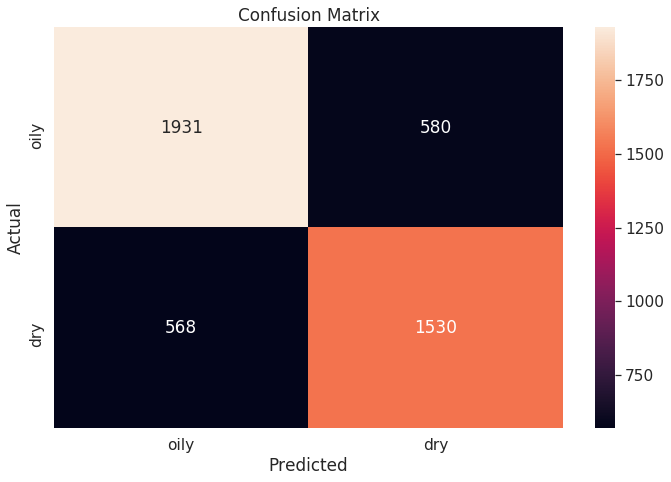

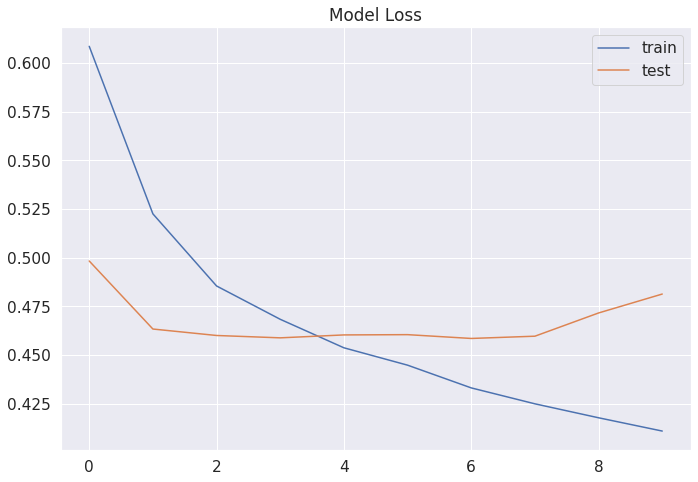

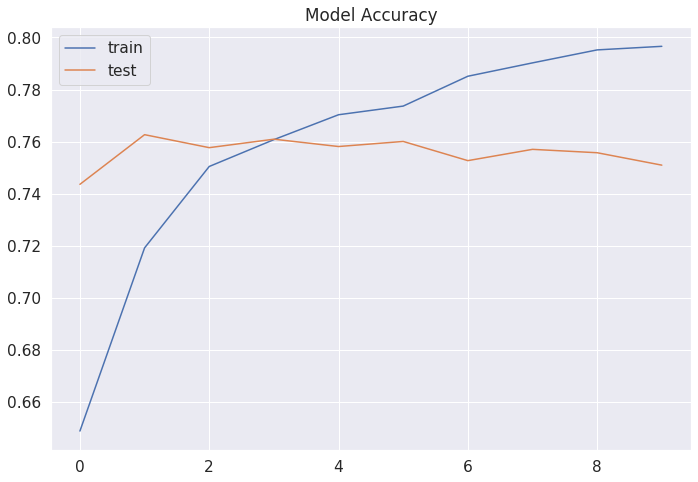

In [273]:
%run src/LSTM_2classes.py

## LSTM model predicting Dry, Oily, & Normal skin

I also constructed another LSTM model to predict dry, oily, and normal skin types. This model, however, does not perform that well and looks to overfit after 1 epoch. Accuracy and loss for the training set improves significantly, while accuracy and loss for the testing set remains at a constant rate across all epochs.

Accuracy is around 57%. The model also appears to have difficulty predicting dry skin types. I can see that many of these are predicted as 'normal' and not 'dry'. 

Train on 57294 samples, validate on 6366 samples
Epoch 1/20
57294/57294 [==============================] - 450s 8ms/sample - loss: 0.9426 - accuracy: 0.5293 - val_loss: 0.8952 - val_accuracy: 0.5641
Epoch 2/20
57294/57294 [==============================] - 449s 8ms/sample - loss: 0.8773 - accuracy: 0.5773 - val_loss: 0.8783 - val_accuracy: 0.5707
Epoch 3/20
57294/57294 [==============================] - 439s 8ms/sample - loss: 0.8480 - accuracy: 0.5897 - val_loss: 0.8910 - val_accuracy: 0.5669
Epoch 4/20
57294/57294 [==============================] - 428s 7ms/sample - loss: 0.8192 - accuracy: 0.6063 - val_loss: 0.8599 - val_accuracy: 0.5752
Epoch 5/20
57294/57294 [==============================] - 415s 7ms/sample - loss: 0.7940 - accuracy: 0.6242 - val_loss: 0.8619 - val_accuracy: 0.5776
Epoch 6/20
57294/57294 [==============================] - 439s 8ms/sample - loss: 0.7704 - accuracy: 0.6381 - val_loss: 0.8650 - val_accuracy: 0.5823
Epoch 7/20
57294/57294 [===========================

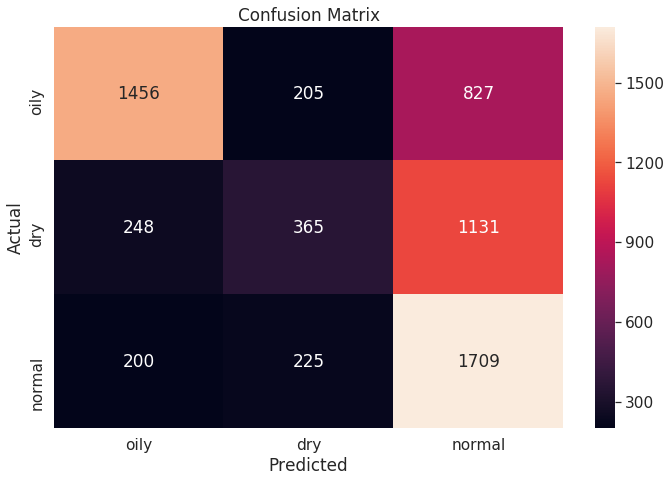

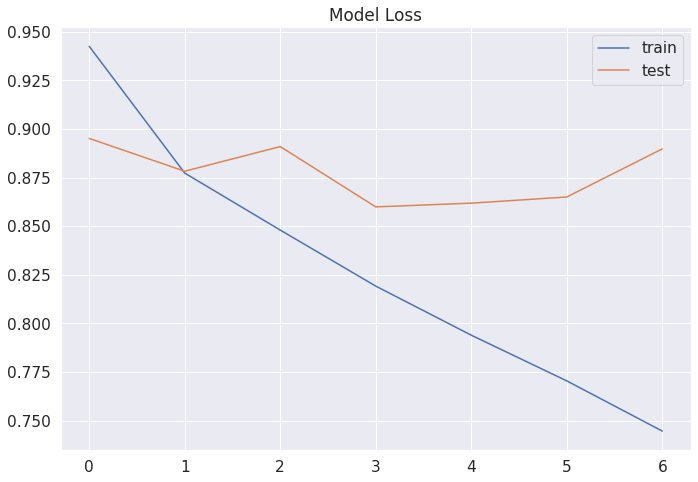

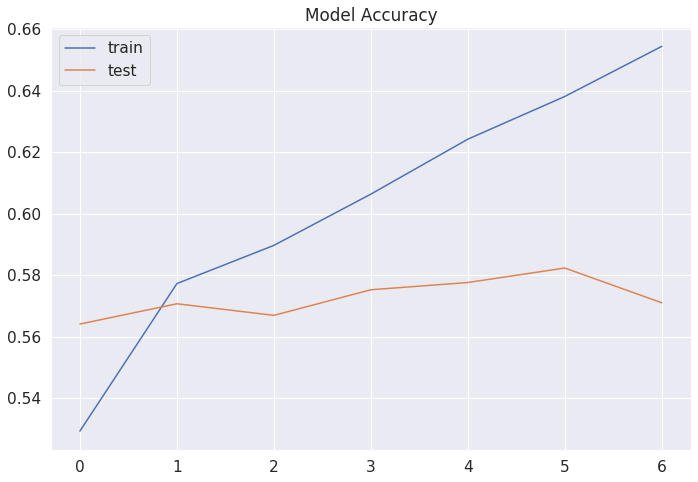

In [285]:
%run src/LSTM_3classes.py